# Rabbani Nur Kumoro - 21/472599/PA/20310
# Computer Vision and Image Analysis - CS - Assignment 3
# Elderly People Fall Detection Using Tracking


# 1. Import Required Libraries

In [1]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

import cv2
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML
from cvzone.PoseModule import PoseDetector

# 2. Object Detection Methods

## a. Keypoints

In [3]:
def draw_keypoints(frame, keypoints, threshold=0.3):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > threshold:
            cv2.circle(frame,(int(kx),int(ky)), 4, (255,0,0), -1)

## b. Edges & Connections

In [4]:
edges = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [5]:
def draw_skeleton(frame, keypoints, edges, threshold=0.3):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        if (c1 > threshold) & (c2 > threshold):
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

## c. Boundaries

In [6]:
def draw_bounding_box(frame, keypoints, threshold=0.3):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))
    x1, y1, x2, y2 = x, y, 0, 0
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > threshold:
            x1, y1 = min(x1, kx), min(y1, ky)
            x2, y2 = max(x2, kx), max(y2, ky)
    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)

## d. Human Detection

In [7]:
# Loop function through each frame in the video
def loop_through_people(frame, keypoints_with_scores, edges, threshold):
    for person in keypoints_with_scores:
        draw_skeleton(frame, person, edges, threshold)
        draw_keypoints(frame, person, threshold)
        draw_bounding_box(frame, person, threshold)

## e. Fall Detection

In [8]:
# Record coordinates of nose
y_coordinates = {
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
}

x_coordinates = {
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
}

# Record aspect ratio of bounding box
aspect_ratios = {
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
}

# Record angle of bounding box
angles = {
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
}

# Record frame when person falls
fall_frames = {
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
}

In [9]:
# Calculate aspect ratio of bounding box
def calculate_aspect_ratio(frame, keypoints_with_scores):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints_with_scores, [y, x, 1]))
    x1, y1, x2, y2 = x, y, 0, 0
    for kp in shaped:
        ky, kx, kp_conf = kp
        x1, y1 = min(x1, kx), min(y1, ky)
        x2, y2 = max(x2, kx), max(y2, ky)
    aspect_ratio = (x2 - x1) / (y2 - y1)
    return aspect_ratio

In [10]:
# Detect fall function
def detect_fall(frame, keypoints_with_scores, frame_count):
    for i, person in enumerate(keypoints_with_scores):
        # Angle based for confirmation
        angle = calculate_angle(frame, person)
        angles[i+1].append(angle)

        # Difference based
        y_current = person[0][0]*frame.shape[0]
        x_current = person[0][1]*frame.shape[1]
        y_coordinates[i+1].append(y_current)
        x_coordinates[i+1].append(x_current)
        
        if len(y_coordinates[i+1]) > 5 and len(x_coordinates[i+1]) > 5:
            # Difference in coordinates of nose
            y_diff = y_coordinates[i+1][-1] - y_coordinates[i+1][-5]
            x_diff = x_coordinates[i+1][-1] - x_coordinates[i+1][-5]
            # cv2.putText(frame, f'Y diff: {str(y_diff)}', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)
            # cv2.putText(frame, f'X diff: {str(x_diff)}', (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)

            # If difference is more than 50, person is falling
            if x_diff - y_diff > 50:
                # Confirm fall with angle
                if angle < 45:
                    fall_frames[i+1].append(frame_count)
                    return True

        # Aspect ratio based
        aspect_ratio = calculate_aspect_ratio(frame, person)
        aspect_ratios[i+1].append(aspect_ratio)
        # cv2.putText(frame, f'Aspect ratio: {str(aspect_ratio)}', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)

        # If aspect ratio is higher than 1.5, person is falling
        if aspect_ratio > 1.5:
            # Confirm fall with angle
            # Confirm fall with angle
                if angle < 45:
                    fall_frames[i+1].append(frame_count)
                    return True

## f. Fall Confirmation

In [11]:
# Calculate angle of centroid with respect to horizontal axis of bounding box per frame
def calculate_angle(frame, keypoints_with_scores):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints_with_scores, [y, x, 1]))
    x1, y1, x2, y2 = x, y, 0, 0
    for kp in shaped:
        ky, kx, kp_conf = kp
        x1, y1 = min(x1, kx), min(y1, ky)
        x2, y2 = max(x2, kx), max(y2, ky)
    centroid = (x1 + x2) / 2, (y1 + y2) / 2
    angle = math.atan2(centroid[1] - y1, centroid[0] - x1) * 180 / math.pi
    return angle

# 3. Testing the Model

#### Load the MoveNet model for multi-pose detection from TensorFlow Hub and assigns its "serving_default" signature to a variable called "movenet".

In [2]:
model = hub.load("https://tfhub.dev/google/movenet/multipose/lightning/1")
movenet = model.signatures['serving_default']

Metal device set to: Apple M1


2023-05-16 19:08:49.057070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-16 19:08:49.057157: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
# Initialize a PoseDetector object
detector = PoseDetector()

def display_video(video):
    # Create a figure for plotting
    fig = plt.figure(figsize=(5, 4))
    # Open the video file
    cap = cv2.VideoCapture(video)
    mov = []

    prevTime = 0

    # Loop through the frames of the video
    while cap.isOpened():
        # Read the next frame from the video
        success, frame = cap.read()

        if not success:
            break

        # Resize the frame
        resize = 0.6
        frame = cv2.resize(frame, (0, 0), fx=resize, fy=resize)

        # Perform pose detection on the frame
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 160, 320)
        img = tf.cast(img, dtype=tf.int32)

        # Detect objects in the image using MoveNet
        result = movenet(img)
        keypoints_with_scores = result['output_0'].numpy()[:,:,:51].reshape(6, 17, 3)

        # Render keypoints
        loop_through_people(frame, keypoints_with_scores, edges, 0.3)

        # Check for fall detection based on specific keypoints
        if detect_fall(frame, keypoints_with_scores, cap.get(cv2.CAP_PROP_POS_FRAMES)):
            cv2.putText(frame, "FALL DETECTED!", (5, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, .75, (0, 0, 255), 2)
        else:
            cv2.putText(frame, "NO FALLING MOTION", (5, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, .75, (0, 255, 0), 2)

        # Convert the image color format for plotting
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = plt.imshow(frame, animated=True)
        plt.axis('off')
        mov.append([img])

    # Set animation parameters and create the animation
    matplotlib.rcParams['animation.embed_limit'] = 1000
    animation = animate.ArtistAnimation(fig, mov, interval=50, repeat_delay=1000)

    # Close the plot figure
    plt.close()

    # Return the animation
    return animation

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


# 4. Results & Exploratory Analysis

### From the graph below, when a Fall is Detected, x coordinates tend to be higher than y. This is due to when a person fall, the person will fall to the ground, which is at the bottom of the frame.

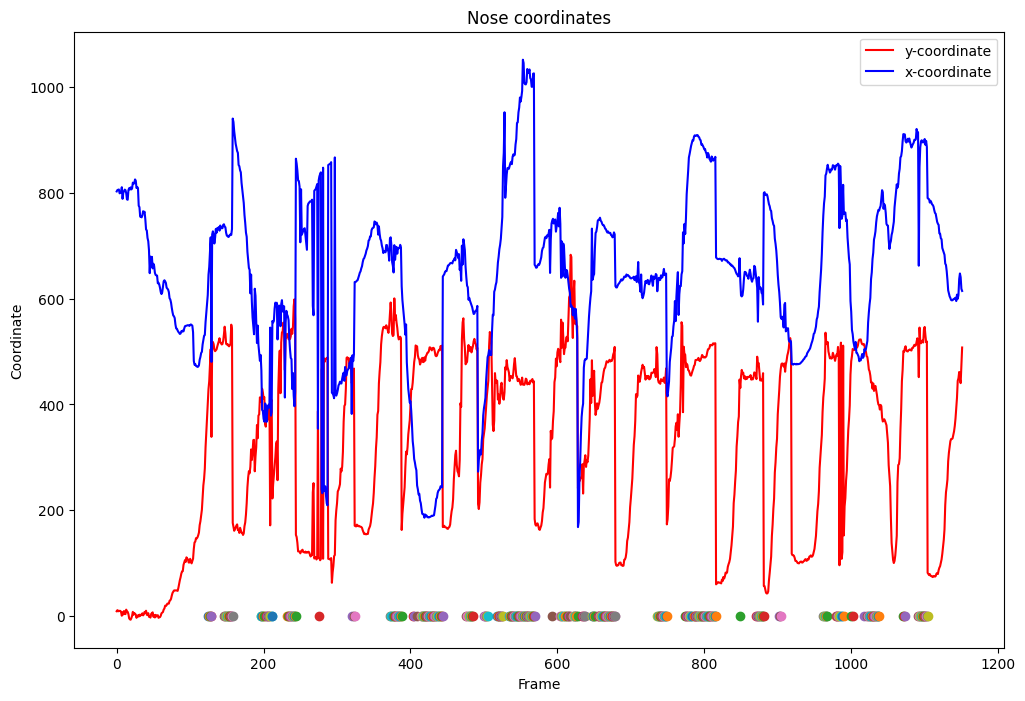

In [ ]:
# Plot the x and y coordinates of the nose
plt.figure(figsize=(12, 8))
plt.plot(y_coordinates[1], label=f'y-coordinate', color='red')
plt.plot(x_coordinates[1], label=f'x-coordinate', color='blue')
for i in range(frame_length):
    if i in fall_frames[1]:
        plt.scatter(i, 1)
plt.title(f'Nose coordinates')
plt.xlabel('Frame')
plt.ylabel('Coordinate')
plt.legend()
plt.show()

### From the graph below, when a fall is detected, the angle of centroid with respect to horizontal axis of bounding box tend to be lower than 45 degrees.

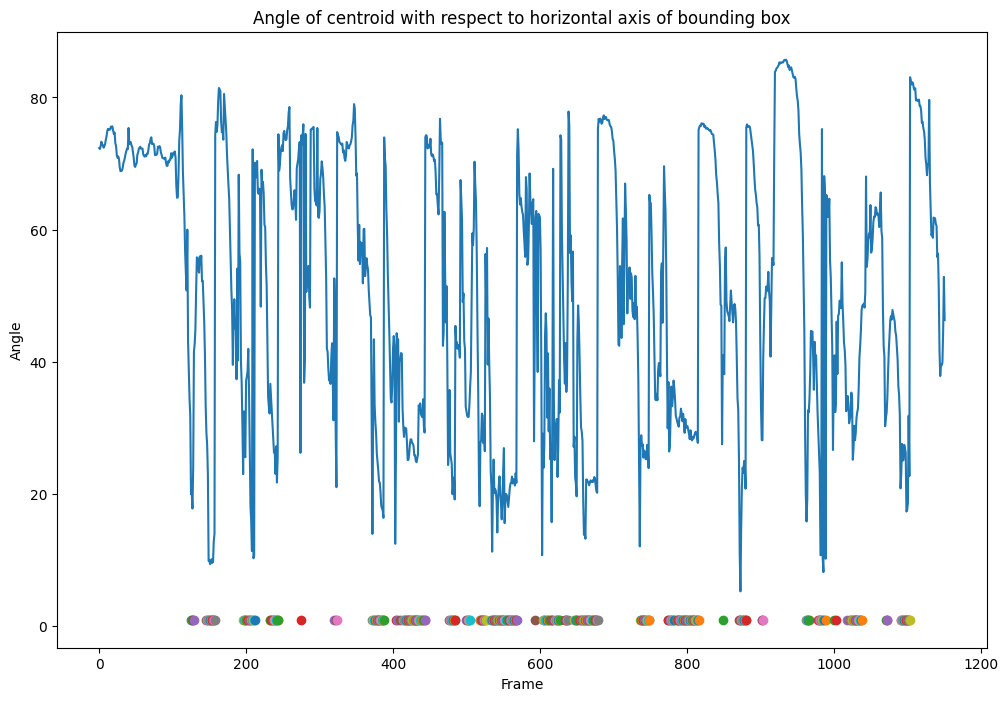

In [ ]:
# Plot the angle for the first person
plt.figure(figsize=(12, 8))
plt.plot(angles[1])
for i in range(frame_length):
    if i in fall_frames[1]:
        plt.scatter(i, 1)
plt.title(f'Angle of centroid with respect to horizontal axis of bounding box')
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.show()

### From the graph below, when a Fall is Detected, the aspect ratio tend to change drastically. This is due to when a person fall, the bounding box will change drastically.

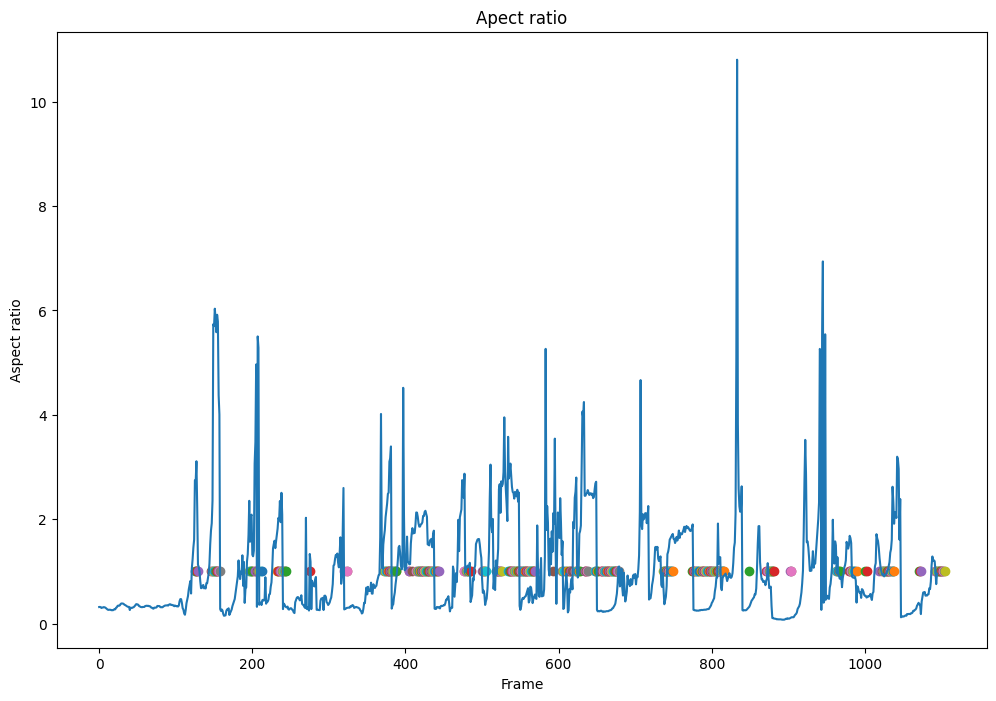

In [ ]:
# Plot the aspect ratio 
plt.figure(figsize=(12, 8))
plt.plot(aspect_ratios[1])
for i in range(frame_length):
    if i in fall_frames[1]:
        plt.scatter(i, 1)
plt.title(f'Apect ratio')
plt.xlabel('Frame')
plt.ylabel('Aspect ratio')
plt.show()